In [6]:
import matplotlib.pyplot as plt
import numpy as np            
import pandas as pd        
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.applications import EfficientNetV2S
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Đường dẫn thư mục train và test
train_path = r'.\train'
test_path = r'.\test'
val_path = r'.\val'

batch_size = 32 
img_height = 224
img_width = 224


In [7]:
# Data augmentation for training
image_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.7,1.3],
    fill_mode='nearest'
)

# Data augmentation for testing/validation
test_data_gen = ImageDataGenerator(rescale=1./255)


In [8]:
# Training data generator
train_generator = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'
)

# Testing data generator
test = test_data_gen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    color_mode='rgb', 
    shuffle=False,
    class_mode='binary',
    batch_size=batch_size
)

# Validation data generator
validation_generator = image_gen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'
)



Found 1943 images belonging to 2 classes.
Found 611 images belonging to 2 classes.
Found 497 images belonging to 2 classes.


In [9]:
print(train_generator.class_indices)

{'1_Normal': 0, '2_Disease': 1}


In [10]:
def create_efficient_model(num_classes=1):
    base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=outputs)
    
    # Mở khóa một số lớp cuối của base model
    for layer in base_model.layers[-30:]:
        layer.trainable = True
    
    return model

efficient_model = create_efficient_model()

# Compile mô hình với learning rate thấp hơn
efficient_model.compile(optimizer=Adam(learning_rate=1e-5), 
                        loss='binary_crossentropy', 
                        metrics=['accuracy', tf.keras.metrics.AUC()])

# Callbacks
early = EarlyStopping(monitor="val_loss", mode="min", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
callbacks_list = [early, reduce_lr]

# Tính class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

# Train mô hình
history = efficient_model.fit(
    train_generator,
    epochs=50,  # Tăng số epochs
    validation_data=validation_generator,
    class_weight=class_weight_dict,
    callbacks=callbacks_list
)


Class weights: {0: 1.763157894736842, 1: 0.6979166666666666}
Epoch 1/50
61/61 [==============================] - 742s 12s/step - loss: 0.6991 - accuracy: 0.5713 - auc: 0.5152 - val_loss: 0.6952 - val_accuracy: 0.4567 - val_auc: 0.4564 - lr: 1.0000e-05
Epoch 2/50
61/61 [==============================] - 707s 12s/step - loss: 0.7005 - accuracy: 0.5291 - auc: 0.5012 - val_loss: 0.6811 - val_accuracy: 0.5674 - val_auc: 0.4938 - lr: 1.0000e-05
Epoch 3/50
61/61 [==============================] - 522s 8s/step - loss: 0.6912 - accuracy: 0.5337 - auc: 0.5511 - val_loss: 0.6723 - val_accuracy: 0.6479 - val_auc: 0.5753 - lr: 1.0000e-05
Epoch 4/50
61/61 [==============================] - 291s 5s/step - loss: 0.6867 - accuracy: 0.5342 - auc: 0.5660 - val_loss: 0.6750 - val_accuracy: 0.5855 - val_auc: 0.5710 - lr: 1.0000e-05
Epoch 5/50
61/61 [==============================] - 292s 5s/step - loss: 0.6865 - accuracy: 0.5404 - auc: 0.5656 - val_loss: 0.6619 - val_accuracy: 0.6559 - val_auc: 0.6173 - lr

In [11]:
efficient_model.save('EfficientNetV2.h5')

c:\Users\admin\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
# Đánh giá mô hình
test_loss, test_acc, test_auc = efficient_model.evaluate(test)
print('Test accuracy:', test_acc)
print('Test AUC:', test_auc)

# Dự đoán và metrics
y_pred_proba = efficient_model.predict(test)
y_pred = (y_pred_proba > 0.5).astype(int)
y_true = test.classes

conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

class_report = classification_report(y_true, y_pred, target_names=['Normal', 'Disease'])
print('Classification Report:')
print(class_report)

tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
recall = sensitivity
f1_score = 2 * (precision * recall) / (precision + recall)

print(f'Sensitivity: {sensitivity * 100:.2f}%')
print(f'Specificity: {specificity * 100:.2f}%')
print(f'F1-Score: {f1_score:.2f}')


20/20 [==============================] - 23s 1s/step - loss: 0.2932 - accuracy: 0.8592 - auc: 0.9536
Test accuracy: 0.8592471480369568
Test AUC: 0.9535913467407227
20/20 [==============================] - 23s 1s/step
Confusion Matrix:
[[181  16]
 [ 70 344]]
Classification Report:
              precision    recall  f1-score   support

      Normal       0.72      0.92      0.81       197
     Disease       0.96      0.83      0.89       414

    accuracy                           0.86       611
   macro avg       0.84      0.87      0.85       611
weighted avg       0.88      0.86      0.86       611

Sensitivity: 83.09%
Specificity: 91.88%
F1-Score: 0.89


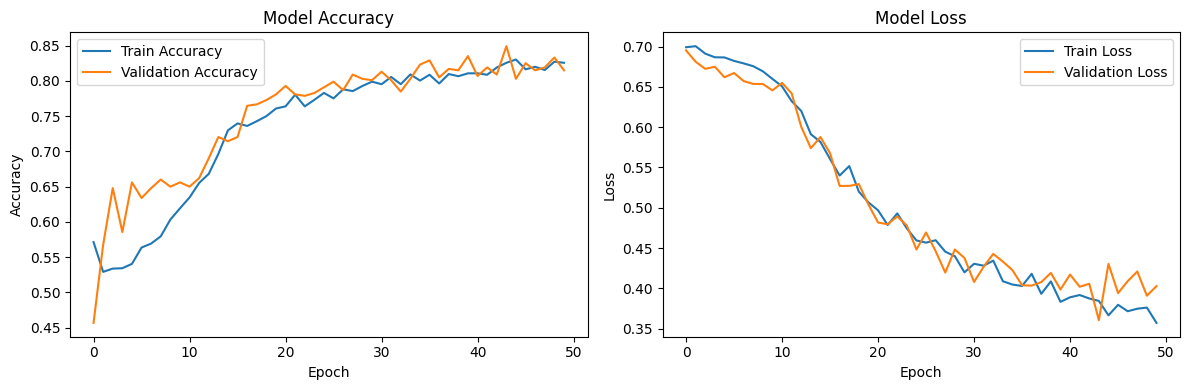

In [13]:
# Vẽ đồ thị lịch sử huấn luyện
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



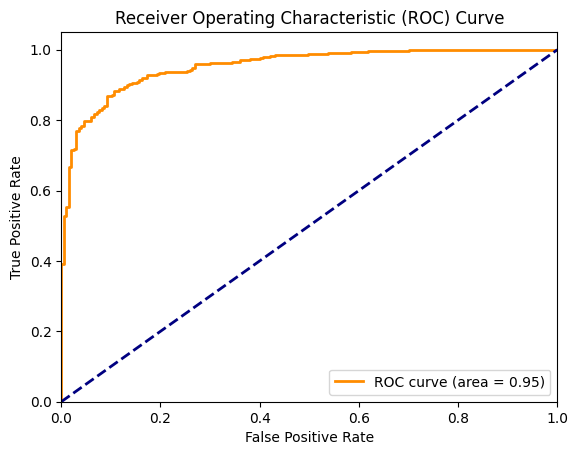

: 

In [14]:
# Vẽ đồ thị ROC curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc = roc_auc_score(y_true, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
